# The hippocampus as a predictive map
Kimberly L Stachenfeld, Matthew M Botvinick & Samuel J Gershman 

https://www.nature.com/articles/nn.4650

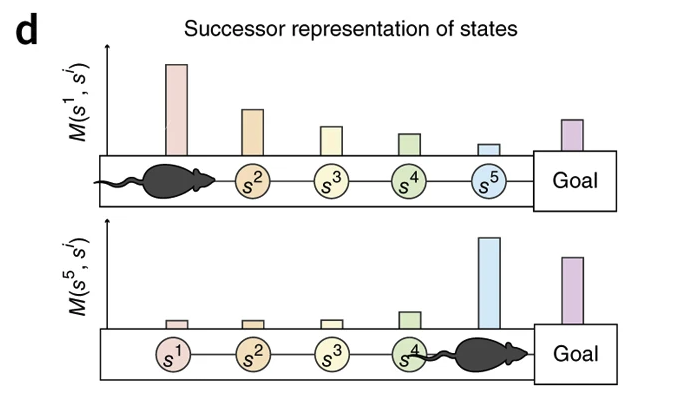

In this notbook we provide easy example on how to run the Succesor Representation (SR) model presented in the paper 'The hippocampus as a predictive map  model'. 
The model is run in multiple different types of environements both generic and build from experimental data.

In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from tqdm.notebook import tqdm
from neuralplayground.arenas import Simple2D, MergingRoom, Sargolini2006, Hafting2008, BasicSargolini2006,Wernle2018
from neuralplayground.utils import create_circular_wall
from neuralplayground.agents import  Stachenfeld2018
import pickle
import pandas as pd


## Initialise the arena

We first create a random 2D arena for the agent to interact with. For more information on how to create arena refer to the arena jupyter notebook.

In [3]:
room_width = [-6,6]
room_depth = [-6,6]
env_name = "env_example"
time_step_size = 0.2
agent_step_size = 0.5
# Init environment
env = Simple2D(environment_name=env_name,
               arena_x_limits = room_width,
               arena_y_limits = room_depth,
               time_step_size = time_step_size,
               agent_step_size = agent_step_size)


## Initialise the SR agent

In [4]:
discount = .9
threshold = 1e-6
lr_td = 0.3
t_episode = 1000
n_episode = 1000
state_density = int(1 / agent_step_size)
agent =  Stachenfeld2018(discount=discount, t_episode=t_episode, n_episode=n_episode, threshold=threshold, lr_td=lr_td,
               room_width=env.room_width, room_depth=env.room_depth, state_density=state_density, twoD=True,
                        agent_step_size=agent_step_size)

If we assume we know the transition matrix  $T_t(s,s′)$ is the probability of transitioning from s to s′ in exactly t step, one can compute the successor representation using successive additive update

$$ M= \sum_{t=0}^{\infty} \gamma^tT^t $$

We use this as sanity check for our results bellow. 

In [5]:
sr_sum= agent.successor_rep_sum()

We plot the transition matrix and the eigenvectors of the Successor Matrix $M$. Choose an array of four eigenvectors you would like to plot. 

array([[0.        , 0.5       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.33333333, 0.        , 0.33333333, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.33333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.33333333,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.33333333, 0.        ,
        0.33333333],
       [0.        , 0.        , 0.        , ..., 0.        , 0.5       ,
        0.        ]])

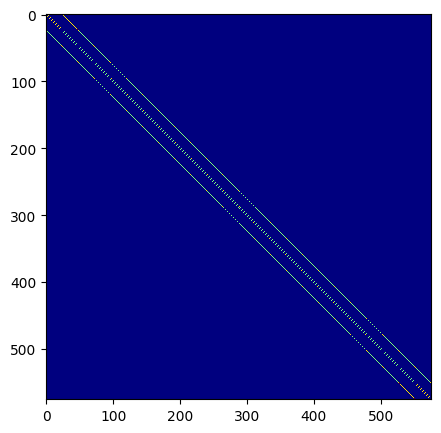

In [6]:
agent.create_transmat(state_density = 0, name_env = "2D_env", plotting_variable=True)

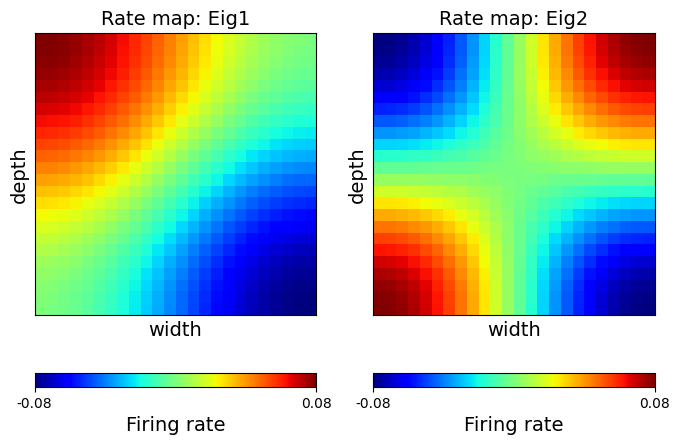

In [7]:
agent.plot_rate_map(sr_matrix = sr_sum, eigen_vectors=[1,2],save_path=None)


One can compute the successor representation matrix using geometric sums for $\gamma<1$
$$ M= \sum_{t=0}^{\infty} \gamma^tT^t =(I-\gamma T)^{-1}$$

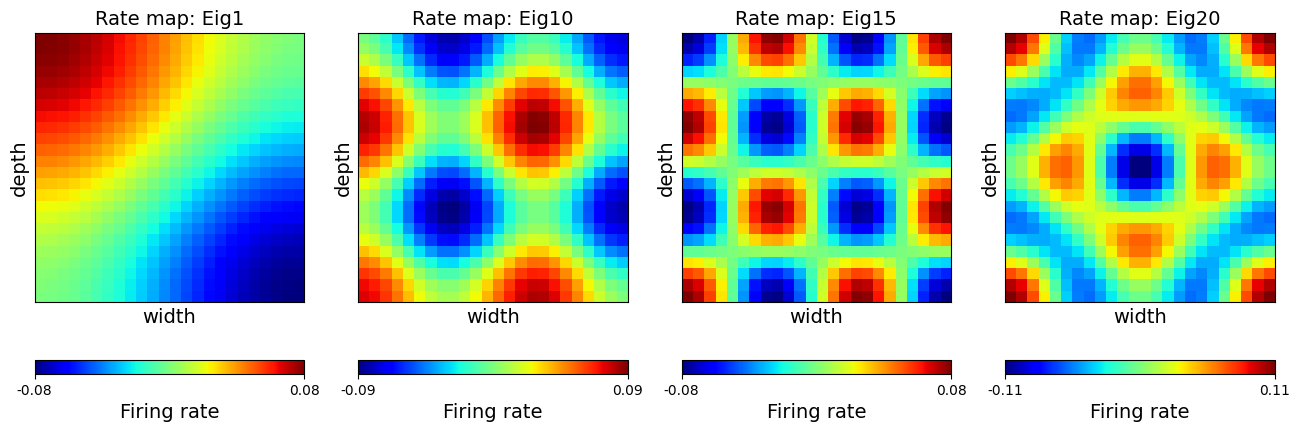

In [8]:
sr = agent.successor_rep_solution()  
agent.plot_rate_map(sr_matrix=sr, eigen_vectors=[1,10,15,20],save_path=None)

Compute the successor representation matrix using TD learning

$$ M_{t+1}(s_t,s')= M_{t}(s_t,s')+\eta[I(s_t=s')+\gamma M_t(s_{t+1},s')-M_t(s_t,s')] $$

In [9]:
help(agent.update_successor_rep_td_full)

Help on method update_successor_rep_td_full in module neuralplayground.agents.stachenfeld_2018:

update_successor_rep_td_full(n_episode: int = 100, t_episode: int = 100) method of neuralplayground.agents.stachenfeld_2018.Stachenfeld2018 instance
    Compute the successor representation matrix using TD learning
    assuming no walls in the 2d environment
    
    Returns:
    ----------
        srmat_full: (n_state, n_state)
            successor representation matrix



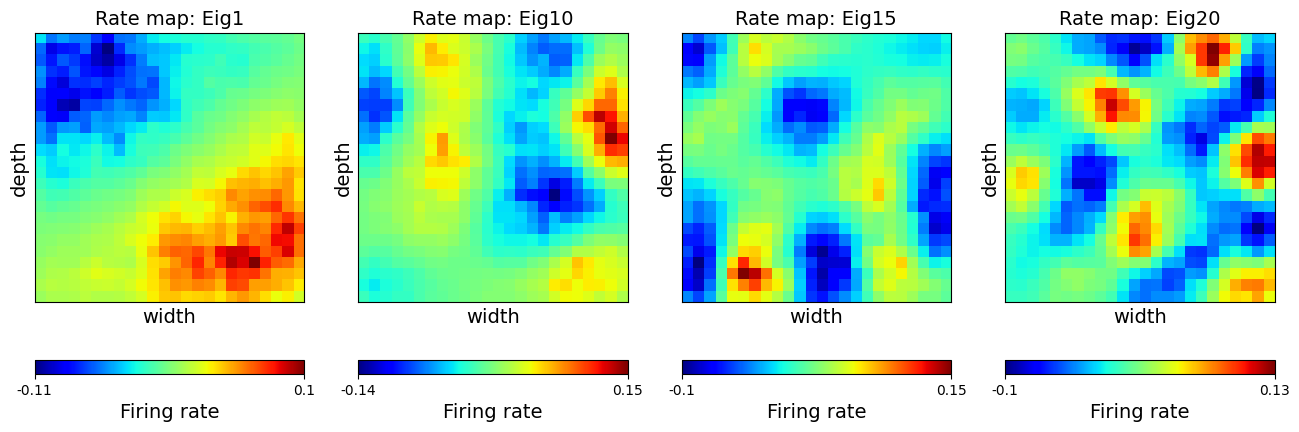

In [10]:
# Choose your function depending on the type of env '2D_env' or '1D_env' 
# Only run if twoDvalue=True
sr_td = agent.update_successor_rep_td_full(n_episode,t_episode)  
agent.plot_rate_map(sr_matrix=sr_td, eigen_vectors=[1,10,15,20], save_path=None)

## Agent and Arena Interaction

The agent receives observations from the environment (reward, visual cues, etc.) and uses these to take an action with the function ``` act```  which in turn will ``` update```  both its state and the state of the environment, generating new observations ```env.step``` . 

We note that the SR model is a discrete model as opposed to the arena which is continous. The discretization is done within the agent concidering that the state representation is build by the agent.

In [11]:
n_episode * t_episode

1000000

  0%|          | 0/100 [00:00<?, ?it/s]

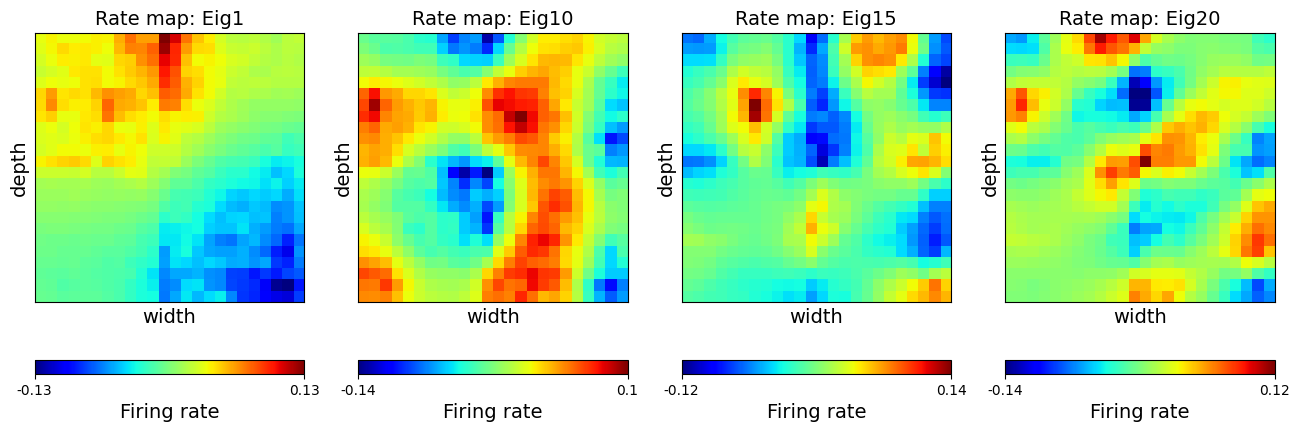

In [12]:
plot_every = 100000
total_iters = 0
n_episode = 100  # overwriting the previous value
obs, state = env.reset()
for i in tqdm(range(n_episode)):
    for j in range(t_episode):
        obs = obs[:2]
        action = agent.act(obs)  # the action is link to density of state to make sure we always land in a new
        obs, new_state, reward = env.step(action)
        agent.update(next_state = obs)
        total_iters += 1
        if total_iters % plot_every == 0:
            agent.plot_rate_map(sr_matrix=agent.srmat, eigen_vectors=[1,10,15,20],save_path='./sr.png')


Plotting the ground truth transition matrix and the transition matrix resulting from the interaction with the environment.

array([<Axes: title={'center': 'Transition matrix'}, xlabel='states', ylabel='states'>,
       <Axes: title={'center': 'Transition calculated from SR matrix'}, xlabel='states', ylabel='states'>],
      dtype=object)

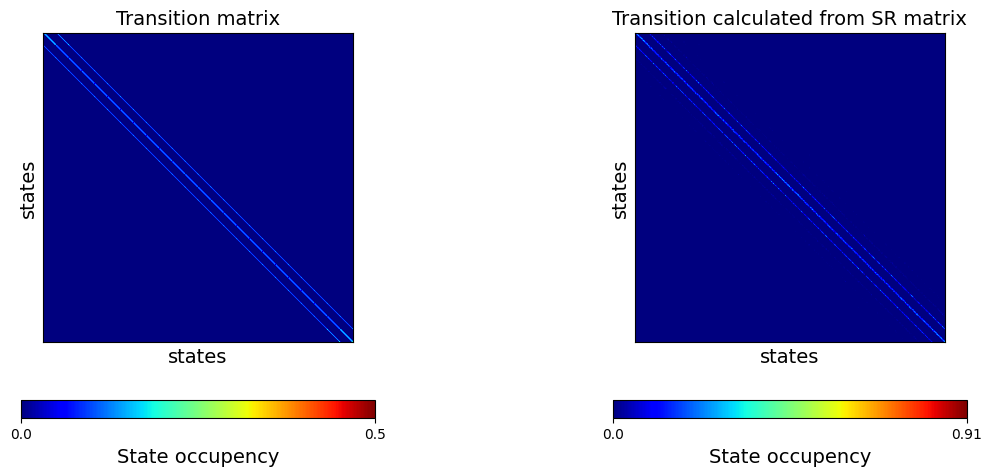

In [13]:
agent.plot_transition()

## Merging room

  0%|          | 0/120000 [00:00<?, ?it/s]

merge done index saved_SR 60000
merge done index saved_SR 60002
merge done index saved_SR 60004
merge done index saved_SR 60006
merge done index saved_SR 60008
merge done index saved_SR 60010
merge done index saved_SR 60012
merge done index saved_SR 60014
merge done index saved_SR 60016
merge done index saved_SR 60018
merge done index saved_SR 60020
merge done index saved_SR 60022
merge done index saved_SR 60024
merge done index saved_SR 60026
merge done index saved_SR 60028
merge done index saved_SR 60030
merge done index saved_SR 60032
merge done index saved_SR 60034
merge done index saved_SR 60036
merge done index saved_SR 60038
merge done index saved_SR 60040
merge done index saved_SR 60042
merge done index saved_SR 60044
merge done index saved_SR 60046
merge done index saved_SR 60048
merge done index saved_SR 60050
merge done index saved_SR 60052
merge done index saved_SR 60054
merge done index saved_SR 60056
merge done index saved_SR 60058
merge done index saved_SR 60060
merge do

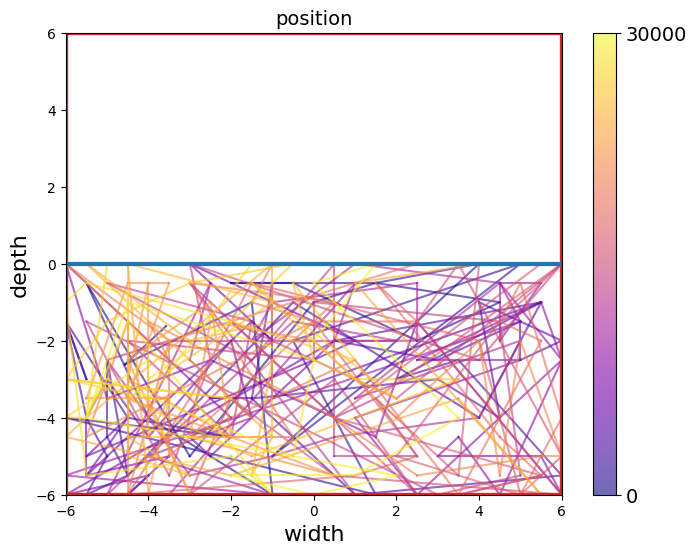

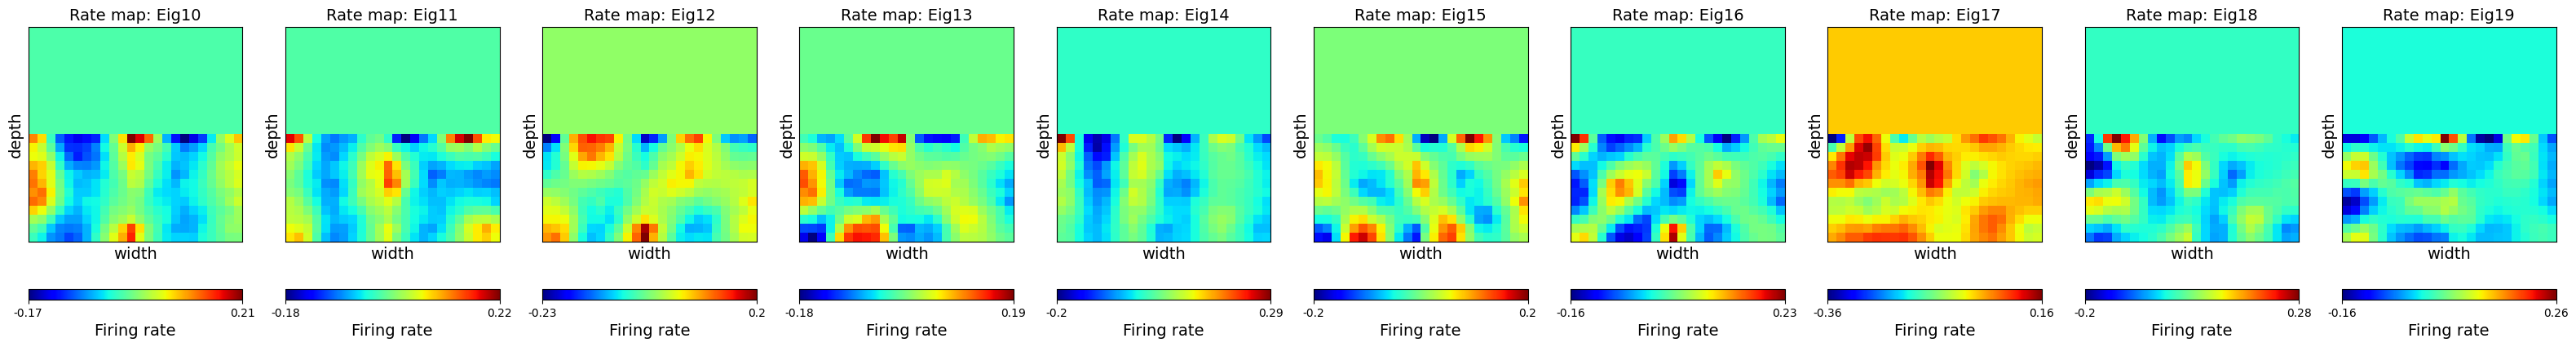

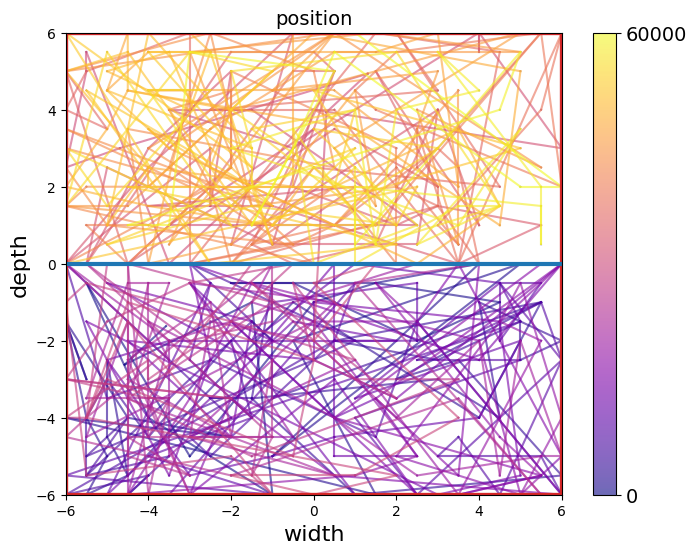

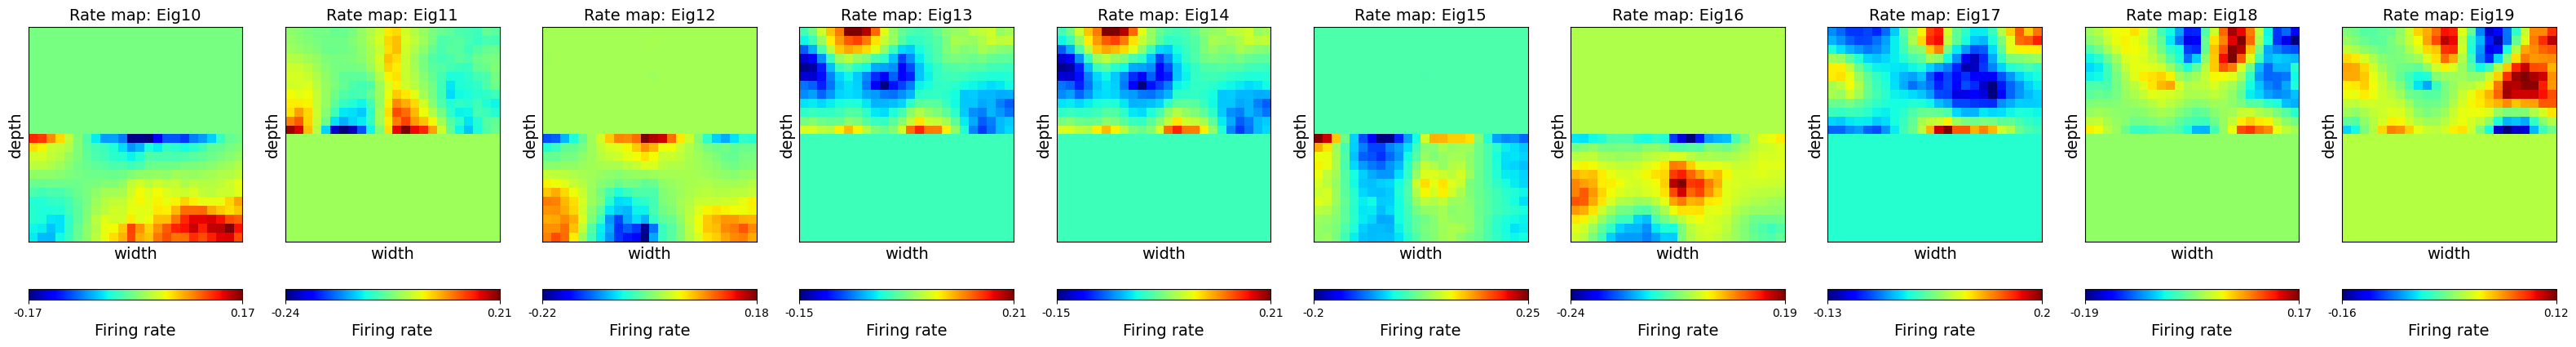

In [14]:
agent_step_size = 0.5
time_step_size = 0.2
block_time_min = 100.0  # default from experiment is 270.0
merging_time = block_time_min*2.0  # Time in minutes to remove 
switch_time = block_time_min # Time in minutes to move the mouse to the other side of the arena
additional_time = block_time_min
n_steps = ((merging_time + switch_time + additional_time)*60) / time_step_size
eigenvectors_to_plot = np.arange(10, 20).astype(int)
max_saved_SR = 500
save_every = 2
saved_SR = 0

room_width = [-6,6]
room_depth = [-6,6]
env_name = "merging_room"

# Init environment
env = MergingRoom(arena_x_limits = room_width,
                  arena_y_limits = room_depth,
                  time_step_size = time_step_size,
                  agent_step_size = agent_step_size,
                  merge_time = merging_time,
                  switch_time = switch_time)


discount = .9
threshold = 1e-6
lr_td = 0.2
t_episode =  1
n_episode = n_steps
state_density = (1 / agent_step_size)
twoDvalue = True

agent_Stachenfeld2018 = Stachenfeld2018(discount=discount, t_episode=t_episode, n_episode=n_episode, threshold=threshold, lr_td=lr_td,
                                        room_width=env.room_width, room_depth=env.room_depth, state_density=state_density, twoD=True,
                                        agent_step_size=agent_step_size)

# We will save the SR matrix, before switch, before merge, and after merge
stages_SR_matrix = {}
after_merge_SR = []

obs, state = env.reset()     
plot_every = 100*100
total_iters = 0
merge_done = False
for j in tqdm(range(round(n_steps))):
    # Observe to choose an action
    action = agent_Stachenfeld2018.act(obs[:2])
    # Run environment for given action
    obs, state, reward = env.step(action)
    agent_Stachenfeld2018.update(next_state=obs[:2])
  
    # We plot the trajectory of the agent just right before switching and before merging
    # then we keep running the loop
    if j == int((switch_time*60)/time_step_size)-1:
        # plot trajectory
        ax = env.plot_trajectory(plot_every=100)
        ax.set_xlabel("width", fontsize=16)
        ax.set_ylabel("depth", fontsize=16)
        # If you like, you can save the current state of the agent using the save_agent method to load the agent later
        agent_Stachenfeld2018.plot_rate_map(sr_matrix=agent_Stachenfeld2018.srmat, eigen_vectors=eigenvectors_to_plot,save_path='./sr.png')

        plt.savefig("pre_switch.pdf", bbox_inches="tight")
        stages_SR_matrix["pre_switch"] = np.copy(agent_Stachenfeld2018.srmat)
    if j == int((merging_time*60)/time_step_size)-1:
        # Same thing, plotting just before the merging of the rooms
        ax = env.plot_trajectory(plot_every=100)
        ax.set_xlabel("width", fontsize=16)
        ax.set_ylabel("depth", fontsize=16)
        agent_Stachenfeld2018.plot_rate_map(sr_matrix=agent_Stachenfeld2018.srmat, eigen_vectors=eigenvectors_to_plot, save_path='./"pre_merge_merging_room.png')
        plt.savefig("pre_merge.pdf", bbox_inches="tight")
        stages_SR_matrix["pre_merge"] = np.copy(agent_Stachenfeld2018.srmat)
        merge_done = True
        after_merge_SR.append(agent_Stachenfeld2018.srmat)
        # agent.save_agent("pre_merge.agent")
    if merge_done and j % save_every == 0 and saved_SR < max_saved_SR:
        print("merge done index saved_SR", j)
        after_merge_SR.append(np.copy(agent_Stachenfeld2018.srmat))
        saved_SR += 1
stages_SR_matrix["post_merge"] = np.copy(agent_Stachenfeld2018.srmat)
stages_SR_matrix["after_merge_evolution"] = np.stack(after_merge_SR)
pickle.dump(stages_SR_matrix, open("stages_SR_matrix.pkl", "wb"), protocol=pickle.HIGHEST_PROTOCOL)

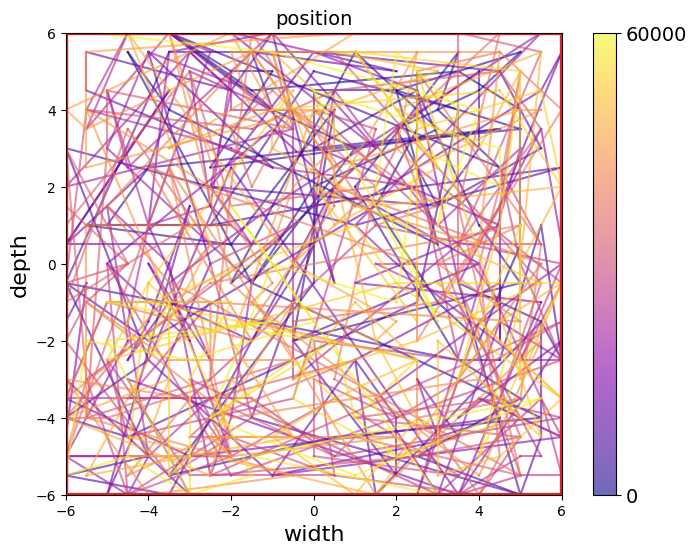

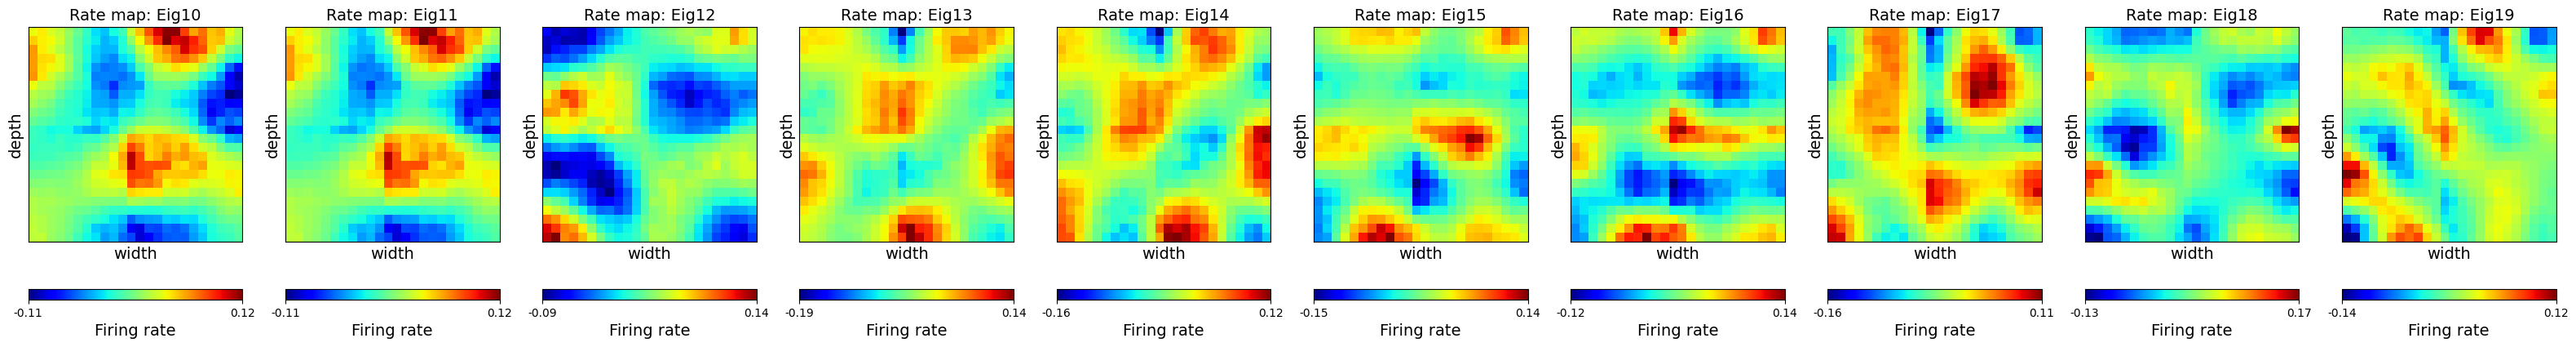

In [15]:
# Here we take the section of interaction history for the period after the merge
merged_history = env.history[int((merging_time*60)/time_step_size):]
# Note that the wall is already removed from the arena structure
ax = env.plot_trajectory(history_data=merged_history, plot_every=100)
ax.set_xlabel("width", fontsize=16)
ax.set_ylabel("depth", fontsize=16)
agent_Stachenfeld2018.plot_rate_map(sr_matrix=agent_Stachenfeld2018.srmat,
                                    eigen_vectors=eigenvectors_to_plot, save_path='./sr_Wernle.png')
plt.savefig("post_merge.pdf", bbox_inches="tight")

## Start here to play with the SR matrix per stage

In [16]:
SR_matrices = pd.read_pickle("stages_SR_matrix.pkl")
for key in SR_matrices.keys():
    print(key, SR_matrices[key].shape)

pre_switch (576, 576)
pre_merge (576, 576)
post_merge (576, 576)
after_merge_evolution (501, 576, 576)


In [17]:
help(agent.get_rate_map_matrix)

Help on method get_rate_map_matrix in module neuralplayground.agents.stachenfeld_2018:

get_rate_map_matrix(sr_matrix=None, eigen_vector: Union[int, list, tuple, numpy.ndarray] = None, get_eigen_vals: bool = False) method of neuralplayground.agents.stachenfeld_2018.Stachenfeld2018 instance
    Compute the rate map matrix from the successor representation matrix using the eigen-decomposition
    Parameters
    ----------
    sr_matrix: array
        Successor representation matrix
    eigen_vector: int, list, tuple, np.ndarray
        The eigen vector to be used to compute the rate map matrix
    get_eigen_vals: bool
        If True, returns the eigen values of the matrix
    Returns
    -------
    r_out_im: array
        The rate map matrix



In [18]:
eigenval_indexes = np.arange(30).astype(int)

In [19]:
all_eigenvec = {}
all_eigenval = {}
for key in SR_matrices.keys():
    if key == "after_merge_evolution":
        continue
    all_eigenval[key] = []
    all_eigenvec[key] = []
    for index in tqdm(eigenval_indexes):
        eigenvec, eigenval = agent_Stachenfeld2018.get_rate_map_matrix(SR_matrices[key], index, get_eigen_vals=True)
        all_eigenval[key].append(eigenval)
        all_eigenvec[key].append(eigenvec)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [20]:
all_eigenval["pre_switch"]

[(9.071249451013685+0j),
 (8.528474128971304+0j),
 (8.357355906326662+0j),
 (8.027552414777047+0j),
 (7.743187182865908+0j),
 (7.396309564927747+0j),
 (7.062056444298008+0j),
 (6.787260411415681+0j),
 (6.475375366552496+0j),
 (6.459380111134018+0j),
 (6.301986116188806+0j),
 (5.952621383949867+0j),
 (5.883193280616592+0j),
 (5.490922271987119+0j),
 (5.354066066418867+0j),
 (5.070552983526369+0j),
 (4.980067867856933+0j),
 (4.845377814914776+0j),
 (4.711079958242298+0j),
 (4.55314031233835+0.048510562332777375j),
 (4.55314031233835-0.048510562332777375j),
 (4.4101244145010465+0j),
 (4.293452536647222+0j),
 (4.153903540092756+0j),
 (3.885360689769531+0.09705182670573738j),
 (3.885360689769531-0.09705182670573738j),
 (3.5824109189874855+0.00977455778211669j),
 (3.5824109189874855-0.00977455778211669j),
 (3.472851831219193+0j),
 (3.4056847848544973+0j)]

  0%|          | 0/30 [00:00<?, ?it/s]

/home/rodrigo/anaconda3/envs/NPG-dev/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

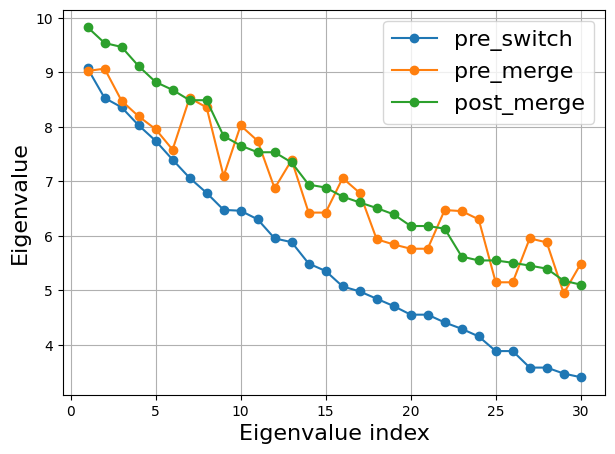

In [21]:
f, ax = plt.subplots(1, 1, figsize=(7, 5))
for i, key in enumerate(SR_matrices.keys()):
    if key == "after_merge_evolution":
        continue
    eigenvals = []
    for index in tqdm(eigenval_indexes):
        eigenvals.append(all_eigenval[key][index])
    ax.plot(eigenval_indexes+1, eigenvals, "-o", label=key)
ax.set_xlabel("Eigenvalue index", fontsize=16)
ax.set_ylabel("Eigenvalue", fontsize=16)
ax.legend(fontsize=16)
ax.grid()
plt.show()

In [22]:
# Changes in eigenvectorrs pre switch vs pre merge
pre_merge_SR = SR_matrices["pre_merge"]
eigenvec_pre_s_pre_m = []
for index in tqdm(eigenval_indexes):
    new_eigenvec = pre_merge_SR @ all_eigenvec["pre_switch"][index].flatten()[:, np.newaxis]
    eigenvec_pre_s_pre_m.append(new_eigenvec.reshape(agent.resolution_width, agent.resolution_depth))
    
post_merge_SR = SR_matrices["post_merge"]
eigenvec_pre_s_post_m = []
eigenvec_pre_m_post_m = []
for index in tqdm(eigenval_indexes):
    new_eigenvec = post_merge_SR @ all_eigenvec["pre_switch"][index].flatten()[:, np.newaxis]
    eigenvec_pre_s_post_m.append(new_eigenvec.reshape(agent.resolution_width, agent.resolution_depth))
    new_eigenvec = post_merge_SR @ all_eigenvec["pre_merge"][index].flatten()[:, np.newaxis]
    eigenvec_pre_m_post_m.append(new_eigenvec.reshape(agent.resolution_width, agent.resolution_depth))

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

To keep track of the changes in the eigenvectors, we can multiply the SR matrix $M(t+\Delta t)$ by the computed eigenvector $v(t)$ of $M(t)$. So $v(t+\Delta t) \lambda(t+\Delta t) = M(t+\Delta t) v(t)$.

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

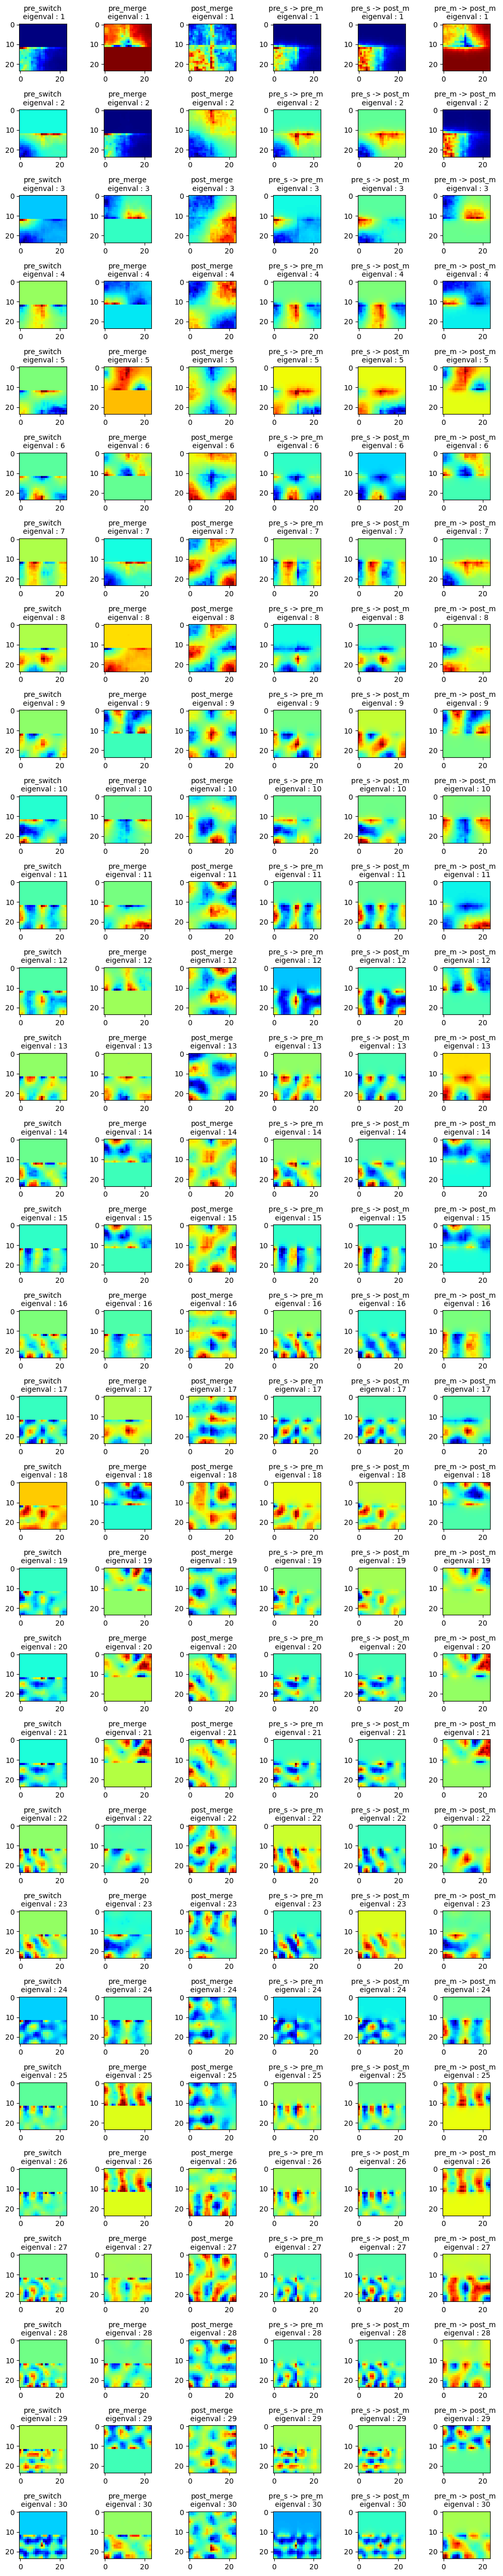

In [23]:
f, ax = plt.subplots(len(eigenval_indexes), 6, figsize=(10, 50))
for i, key in enumerate(SR_matrices.keys()):
    if key == "after_merge_evolution":
        continue
    for index in tqdm(eigenval_indexes):
        ax[index, i].imshow(all_eigenvec[key][index].reshape(agent.resolution_width, agent.resolution_depth), cmap="jet")
        ax[index, i].set_title(key + "\n eigenval : " + str(index+1), fontsize=10)

for index in tqdm(eigenval_indexes):
    ax[index, 3].imshow(eigenvec_pre_s_pre_m[index], cmap="jet")
    ax[index, 3].set_title("pre_s -> pre_m \n eigenval : " + str(index+1), fontsize=10)
    ax[index, 4].imshow(eigenvec_pre_s_post_m[index], cmap="jet")
    ax[index, 4].set_title("pre_s -> post_m \n eigenval : " + str(index+1), fontsize=10)
    ax[index, 5].imshow(eigenvec_pre_m_post_m[index], cmap="jet")
    ax[index, 5].set_title("pre_m -> post_m \n eigenval : " + str(index+1), fontsize=10)

f.tight_layout()

In [24]:
SR_matrices["pre_merge"]

array([[2.46710248, 0.54046282, 0.27626981, ..., 0.        , 0.        ,
        0.        ],
       [1.08237186, 1.93798676, 0.6132189 , ..., 0.        , 0.        ,
        0.        ],
       [0.60988552, 1.56114391, 2.04265373, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 2.07355088, 0.66341816,
        0.31927138],
       [0.        , 0.        , 0.        , ..., 0.66266359, 1.98001851,
        1.44086409],
       [0.        , 0.        , 0.        , ..., 0.34640078, 0.70701878,
        2.41281623]])

In [25]:
after_merge_evolution = SR_matrices["after_merge_evolution"]

In [26]:
after_merge_evolution[-1, ...]

array([[2.63778423, 1.17408171, 0.34237769, ..., 0.        , 0.        ,
        0.        ],
       [1.15193384, 1.88734275, 0.77067755, ..., 0.        , 0.        ,
        0.        ],
       [0.7295144 , 1.06185482, 2.21643592, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 2.07355088, 0.66341816,
        0.31927138],
       [0.        , 0.        , 0.        , ..., 0.66266359, 1.98001851,
        1.44086409],
       [0.        , 0.        , 0.        , ..., 0.34640078, 0.70701878,
        2.41281623]])

In [27]:
after_merge_evolution[0, ...]

array([[2.32785414e+00, 7.68384102e-01, 3.58414854e-01, ...,
        2.75652523e-16, 8.99799006e-17, 1.17098746e-17],
       [1.18619682e+00, 2.01201882e+00, 8.12832342e-01, ...,
        2.92908653e-15, 9.70882383e-16, 1.36142624e-16],
       [5.36863259e-01, 1.02108054e+00, 2.28019437e+00, ...,
        5.97966471e-15, 1.98357739e-15, 2.79153674e-16],
       ...,
       [3.19645442e-18, 1.35626688e-17, 5.35081071e-17, ...,
        2.01847426e+00, 1.05047481e+00, 4.40041159e-01],
       [2.38305478e-18, 1.11832243e-17, 4.58879715e-17, ...,
        5.71890023e-01, 1.77031423e+00, 9.79799658e-01],
       [1.03788851e-18, 5.00145679e-18, 2.07904474e-17, ...,
        3.08326574e-01, 7.87081830e-01, 2.63626251e+00]])

In [28]:
after_merge_evolution.shape

(501, 576, 576)

In [29]:
time_steps = after_merge_evolution.shape[0]
eigenvals_list = []
up_down_index = []
for t in tqdm(range(after_merge_evolution.shape[0])):
    sr_t = after_merge_evolution[t, :, :]
    eigenvecs, eigenvals = agent_Stachenfeld2018.get_rate_map_matrix(sr_t, eigenval_indexes.astype(int), get_eigen_vals=True)
    up_down_eigen_index = []
    for index in eigenval_indexes:
        upper_row = eigenvecs[index, 5, :]
        lower_row = eigenvecs[index, 20, :]
        if np.var(upper_row) > np.var(lower_row):
            up_down_eigen_index.append(True)
        else:
            up_down_eigen_index.append(False)
    up_down_index.append(np.array(up_down_eigen_index))
    eigenvals_list.append(eigenvals)
up_down_index = np.stack(up_down_index)
eigenvals_list = np.stack(eigenvals_list)

  0%|          | 0/501 [00:00<?, ?it/s]

In [30]:
eigenvals_list.shape
eigenvals_list[:, -1]

array([5.10358999+0.j        , 5.3479704 +0.j        ,
       5.4857485 +0.j        , 5.4857485 +0.j        ,
       5.4857485 +0.j        , 5.4857485 +0.j        ,
       5.3479704 +0.j        , 5.3479704 +0.j        ,
       5.3479704 +0.j        , 5.4857485 +0.j        ,
       4.94308464+0.j        , 5.3479704 +0.j        ,
       5.3479704 +0.j        , 5.3479704 +0.j        ,
       5.3479704 +0.j        , 5.4857485 +0.j        ,
       4.94338923+0.j        , 5.3479704 +0.j        ,
       5.4857485 +0.j        , 5.3479704 +0.j        ,
       5.3479704 +0.j        , 5.3479704 +0.j        ,
       5.3479704 +0.j        , 5.4857485 +0.j        ,
       5.4857485 +0.j        , 5.4857485 +0.j        ,
       5.3479704 +0.j        , 5.4857485 +0.j        ,
       4.94098165+0.j        , 5.3479704 +0.j        ,
       5.4857485 +0.j        , 4.94042251+0.j        ,
       4.5474329 +0.23089165j, 5.3479704 +0.j        ,
       5.4857485 +0.j        , 5.3479704 +0.j        ,
       5.3

/home/rodrigo/anaconda3/envs/NPG-dev/lib/python3.11/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


Text(0, 0.5, 'Eigenvalue')

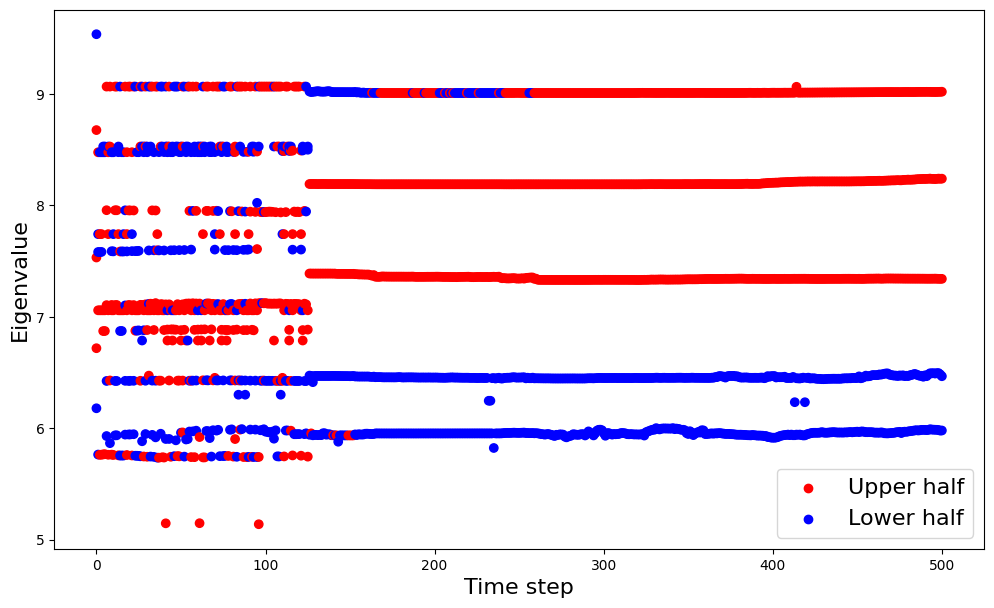

In [31]:
f, ax = plt.subplots(1, 1, figsize=(12, 7))
sub_eigen_indexes = np.array([1, 5, 10, 15, 20])
for t in range(time_steps):
    x_scatter = np.ones(len(sub_eigen_indexes))*t
    colors = ["r" if up_down_index[t, i] else "b" for i in sub_eigen_indexes]
    ax.scatter(x_scatter, eigenvals_list[t, sub_eigen_indexes], c=colors)
    # Custom legend with color code
ax.scatter([], [], c="r", label="Upper half")
ax.scatter([], [], c="b", label="Lower half")
ax.legend(fontsize=16)
ax.set_xlabel("Time step", fontsize=16)
ax.set_ylabel("Eigenvalue", fontsize=16)

In [ ]:
class CircularArena(Simple2D):
    
    def _create_custom_walls(self):
        self.custom_walls = create_circular_wall(center=np.array([0, 0]), radius=50)  # One inner circle
        self.custom_walls += create_circular_wall(center=np.array([0, 0]), radius=75)  # One outer circle
        

In [ ]:
time_step_size = 1 #seg
agent_step_size = 1
arena_x_limits = np.array((-100, 100))
arena_y_limits = np.array((-100, 100))

# Init environment
env = CircularArena(time_step_size = time_step_size,
                    agent_step_size = agent_step_size,
                    arena_x_limits=arena_x_limits,
                    arena_y_limits=arena_y_limits)

In [ ]:
discount = .9
threshold = 1e-6
lr_td = 1e-2
t_episode = 10
n_episode = 10
state_density = int(1 / agent_step_size)
agent =  Stachenfeld2018(discount=discount, t_episode=t_episode, n_episode=n_episode, threshold=threshold, lr_td=lr_td,
               room_width=env.room_width, room_depth=env.room_depth, state_density=state_density,twoD=True)

We do not expect that have good grid cells here as the state covers the all arena. One can consider building specific state space strucutre that is not 2D.

In [ ]:
plot_every = 1000
total_iters = 0
obs, state = env.reset(custom_state=[-70,0])
for i in tqdm(range(n_episode)):
    for j in range(t_episode):
        action = agent.act(obs)  # the action is link to density of state to make sure we always land in a new
        agent.update()
        obs, state, reward = env.step(action)
        obs = obs[:2]
        total_iters += 1
        if total_iters % plot_every == 0:
            agent.plot_rate_map(sr_matrix=agent.srmat, eigen=[1,10,15,20],save_path=None)

In [ ]:
ax = env.plot_trajectory()

ax.grid()
# ax.legend(fontsize=fontsize, loc="upper left")
ax.set_xlabel("width", fontsize=16)
ax.set_ylabel("depth", fontsize=16)
plt.savefig("circle.pdf", bbox_inches="tight")
plt.show()

## Experimental arenas

### Sargolini et al, 2006

We start with the data set from *Conjunctive Representation of Position, Direction, and Velocity in Entorhinal Cortex*, Sargolini et al 2006 (https://www.science.org/doi/10.1126/science.1125572)

Here we use the real behaviour data of the experiment.
Default is False and runs a random agent.

In [ ]:
env = Sargolini2006(time_step_size=0.1,
                         agent_step_size=None, use_behavioral_data = True, recording_index=2)
    

Initialise the agent in this new environement

In [ ]:
agent_step_size = 10
discount = .9
threshold = 1e-6
lr_td = 1e-2
t_episode = 1000
n_episode = 100
state_density = (1 / agent_step_size)
twoDvalue = True
print(env.room_width)
print(env.room_depth)
agent = Stachenfeld2018(discount=discount, t_episode=t_episode, n_episode=n_episode, threshold=threshold, lr_td=lr_td,
               room_width=env.room_width, room_depth=env.room_depth, state_density=state_density, twoD=twoDvalue)



In [ ]:
sr = agent.update_successor_rep_td_full(n_episode=100, t_episode=100) # One can compute the successor representation using successive additive update
agent.plot_rate_map(agent.srmat_full_td, eigen_vectors=[1,10,15,20],save_path=None)
agent.plot_rate_map(sr, eigen_vectors=[1,10,15,20],save_path=None)

sr_sum = agent.successor_rep_sum() # One can compute the successor representation matrix using geometric sums for $\gamma<1$
agent.plot_rate_map(agent.srmat_sum, eigen_vectors=[1,10,15,20],save_path=None)
agent.plot_rate_map(sr_sum, eigen_vectors=[1,10,15,20],save_path=None)


srmat_ground=agent.successor_rep_solution()
agent.plot_rate_map(agent.srmat_ground, eigen_vectors=[1,10,15,20],save_path=None)
agent.plot_rate_map(srmat_ground, eigen_vectors=10,save_path ='./grids_sr_2')

Agent and Arena Interaction

In [ ]:
plot_every = 1000000
total_iters = 0
obs, state = env.reset()
for i in tqdm(range(1000000)):
# Observe to choose an action
    action = agent.act(obs[:2])  # the action is link to density of state to make sure we always land in a new
    agent.update()
    obs, state, reward = env.step(action)
    obs= obs[:2]
    total_iters += 1
    if total_iters % plot_every == 0:
        agent.plot_rate_map(sr_matrix=agent.srmat,eigen_vectors=[1,10,15,20], save_path='./sr_Sargo.png')
        

Plotting the ground truth transition matrix and the transition matrix resulting from the interaction with the environment.

In [ ]:
agent.successor_rep_solution()
T = agent.get_T_from_M(agent.srmat_ground)
agent.plot_transition()

In [ ]:
ax = env.plot_trajectory()
ax.grid()
# ax.legend(fontsize=fontsize, loc="upper left")
ax.set_xlabel("width", fontsize=16)
ax.set_ylabel("depth", fontsize=16)
plt.savefig("sargolini.pdf", bbox_inches="tight")
plt.show()

### Hafting et al, 2008

Let's look at *Hippocampus-independent phase precession in entorhinal grid cells* by Hafting et al 2008 (https://www.nature.com/articles/nature06957)

In [ ]:
env = Hafting2008(time_step_size=0.1,
                  agent_step_size=None,
                  use_behavioral_data=False)
    

Initialise the agent in this new environement

In [ ]:
agent_step_size = 10
discount = .9
threshold = 1e-6
lr_td = 1e-2
t_episode = 1000
n_episode = 100
state_density = (1 / agent_step_size)
twoDvalue = True

agent = Stachenfeld2018(discount=discount, t_episode=t_episode, n_episode=n_episode, threshold=threshold, lr_td=lr_td,
               room_width=env.room_width, room_depth=env.room_depth, state_density=state_density, twoD=twoDvalue)



In [ ]:
sr = agent.update_successor_rep_td_full(n_episode=100, t_episode=100) # One can compute the successor representation using successive additive update
agent.plot_rate_map(agent.srmat_full_td, eigen_vectors=[1,10,15,20],save_path=None)
agent.plot_rate_map(sr, eigen_vectors=[1,10,15,20],save_path=None)

sr_sum = agent.successor_rep_sum() # One can compute the successor representation matrix using geometric sums for $\gamma<1$
agent.plot_rate_map(agent.srmat_sum, eigen_vectors=[1,10,15,20],save_path=None)
agent.plot_rate_map(sr_sum, eigen_vectors=[1,10,15,20],save_path=None)


srmat_ground=agent.successor_rep_solution()
agent.plot_rate_map(agent.srmat_ground, eigen_vectors=[1,10,15,20],save_path=None)
agent.plot_rate_map(srmat_ground, eigen_vectors=[1,10,15,20],save_path=None)

Agent and Arena Interaction

In [ ]:
plot_every = 100000
total_iters = 0
obs, state = env.reset()
obs = obs[:2]
for i in tqdm(range(100000)):
# Observe to choose an action
    action = agent.act(obs)  # the action is link to density of state to make sure we always land in a new
    K  = agent.update()
    obs, state, reward = env.step(action)
    obs= obs[:2]
    total_iters += 1
    if total_iters % plot_every == 0:
        agent.plot_rate_map(sr_matrix=agent.srmat,eigen_vectors=[1,10,15,20], save_path='./sr_Hating.png')

In [ ]:
print(env.room_depth)

Plotting the ground truth transition matrix and the transition matrix resulting from the interaction with the environment.

In [ ]:
T = agent.get_T_from_M(agent.srmat_ground)
agent.plot_transition()

In [ ]:
ax = env.plot_trajectory(plot_every=100)
plt.show()

### Wernle et al, 2018

- *Integration of grid maps in merged environments*, Wernle et al. 2018 (https://www.nature.com/articles/s41593-017-0036-6)

In [ ]:
import sys
sys.path.append("../")
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from tqdm import tqdm
from neuralplayground.arenas import Simple2D, MergingRoom, Sargolini2006, Hafting2008, BasicSargolini2006,Wernle2018
from neuralplayground.utils import create_circular_wall
from neuralplayground.agents import  Stachenfeld2018

In [ ]:
agent_step_size=10
time_step_size = 0.5
merging_time = 170*2.0  # Time in minutes to remove 
switch_time = 170.0 # Time in minutes to move the mouse to the other side of the arena
additional_time = 1470.0
n_steps = ((merging_time + switch_time + additional_time)*60) / time_step_size

env = Wernle2018(merge_time=merging_time,
                 switch_time=switch_time,
                 time_step_size=time_step_size,
                 agent_step_size=agent_step_size)


Initialise the agent in this new environement

In [ ]:
discount = .9
threshold = 1e-6
lr_td = 1e-2
t_episode =  1
n_episode =n_steps
state_density = (1 / agent_step_size)
twoDvalue = True

agent = Stachenfeld2018(discount=discount, t_episode=t_episode, n_episode=n_episode, threshold=threshold, lr_td=lr_td,
               room_width=env.room_width, room_depth=env.room_depth, state_density=state_density, twoD=twoDvalue)



In [ ]:
env.room_width

Agent and Arena interaction

In [ ]:
obs, state = env.reset()       
for j in tqdm(range(round(n_steps))):
    # Observe to choose an action
    action = agent.act(obs[:2])
    # Run environment for given action
    obs, state, reward = env.step(action)
    K  = agent.update()
    # We plot the trajectory of the agent just right before switching and before merging
    # then we keep running the loop
    if j == int((switch_time*60)/time_step_size)-1:
        # plot trajectory
        ax = env.plot_trajectory(plot_every=100)
        ax.set_xlabel("width", fontsize=16)
        ax.set_ylabel("depth", fontsize=16)
        # If you like, you can save the current state of the agent using the save_agent method to load the agent later
        # agent.save_agent("pre_switch.agent")
        # plot rates
        agent.plot_rate_map(sr_matrix=agent.srmat,eigen_vectors=[1,10,15,20], save_path='./sr_pre_switch_time.png')
        plt.savefig("pre_switch.pdf", bbox_inches="tight")
    if j == int((merging_time*60)/time_step_size)-1:
        # Same thing, plotting just before the merging of the rooms
        ax = env.plot_trajectory(plot_every=100)
        ax.set_xlabel("width", fontsize=16)
        ax.set_ylabel("depth", fontsize=16)
        agent.plot_rate_map(sr_matrix=agent.srmat,eigen_vectors=[1,10,15,20], save_path='./sr_pre_merge_time.png')
        plt.savefig("pre_merge.pdf", bbox_inches="tight")
        # agent.save_agent("pre_merge.agent")

Plotting the ground truth transition matrix and the transition matrix resulting from the interaction with the environment.

In [ ]:
# Here we take the section of interaction history for the period after the merge
merged_history = env.history[int((merging_time*60)/time_step_size):]
# Note that the wall is already removed from the arena structure
ax = env.plot_trajectory(history_data=merged_history, plot_every=100)
ax.set_xlabel("width", fontsize=16)
ax.set_ylabel("depth", fontsize=16)
agent.plot_rate_map(sr_matrix=agent.srmat,eigen_vectors=[1,10,15,20], save_path='./sr_Wernle.png')
plt.savefig("post_merge.pdf", bbox_inches="tight")

In [ ]:
agent.plot_transition()

In [ ]:
agent.successor_rep_solution()
T = agent.get_T_from_M(agent.srmat_ground)
agent.plot_transition(T=T)